<a href="https://colab.research.google.com/github/alelovato/CECAM_School/blob/main/HO_NQS_determinant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Harmonic Oscillator

Here we compute the ground-state of the $ndim$-dimensional quantum harmonic oscillator for a system of $npart$ particles. The Hamiltonian of the system reads:

$$ H = -\frac{1}{2m} \sum_{i=1}^{npart} \vec{\nabla}_i^2 + \frac{m \omega^2}{2}\sum_{i=1}^{npart} \vec{x}_i^2 $$

For simplicity, we take $m=1$ and $\omega=1$. According to the variational principle of quantum mechanics, for any bosonic variational wave function $|\psi_V\rangle$,

$$ \frac{\langle \psi_V | H | \psi_V \rangle}{\langle \psi_V | \psi_V \rangle} ~ \ge ~ E_0 = \frac{1}{2} ndim * npart $$

In this notebook, we solve both a system of bosons and a system of fermions. The boson ansatz reads:

$$ \langle R | \psi_V \rangle = \psi_V(R) = \exp \left[\sum_i \mathcal{U}(\vec{r}_i)\right]$$

Note that the ground state corresponds to

$$ \psi_0(R) = \exp \left(-\frac{1}{2}\sum_i \vec{r}_i^2\right) $$


In [1]:
# Load the libraries that we need for this notebook
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

import jax
import jaxlib
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, grad, jit, vmap, pmap, jacfwd, jacrev
from jax.example_libraries import stax
from jax.lax import fori_loop
from functools import partial

from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, Gelu, LogSoftmax, Softplus, Tanh,
                                   Sigmoid, elementwise, FanOut, FanInConcat)
from jax.nn.initializers import glorot_normal, normal, ones, zeros

from jax.tree_util import tree_flatten
from jax.flatten_util import ravel_pytree
from jax.scipy.linalg import cho_factor, cho_solve

In [2]:
class WavefunctionBoson(object):
    """Create a wave function in ndim dimensions and for npart
    bosons using a dense complex feed-forward neural net as
    a building block
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart
        self.activation = Tanh
        self.ndense = 16

    def build(self, key):
        in_shape = (-1, self.ndim)

        self.dense_init, self.dense_apply = stax.serial(
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(1),
)
        key, key_input = jax.random.split(key)
        _, amplitude_params = self.dense_init(key_input, in_shape)

        key, key_input = jax.random.split(key)
        _, phase_params = self.dense_init(key_input, in_shape)

        net_params = [amplitude_params] + [phase_params]

        net_params = jax.tree_util.tree_map(self.update_cast, net_params)
        flat_net_params = self.flatten_params(net_params)
        num_flat_params = flat_net_params.shape[0]

        return net_params, num_flat_params

    @partial(jit, static_argnums=(0,))
    def logpsi(self, params, r):

        amplitude_params, phase_params = params
        amplitude = self.dense_apply(amplitude_params, r)
        phase = self.dense_apply(phase_params, r)

        logpsi = amplitude + 1j * jnp.pi * phase
        logpsi = jnp.sum(logpsi, axis = 0) # Here I am summing over the particles; only valid for bosons
        logpsi = jnp.reshape(logpsi, ())
        logpsi = logpsi - 0.04 * jnp.sum(r**2)
        return logpsi

    @partial(jit, static_argnums=(0,))
    def vmap_logpsi(self, params, r):
        vmap_logpsi = vmap(self.logpsi, in_axes=(None, 0))(params, r)
        return vmap_logpsi

    @partial(jit, static_argnums=(0,))
    def flatten_params(self, parameters):
        flatten_parameters, self.unravel = ravel_pytree(parameters)
        return flatten_parameters

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flatten_parameters):
        unflatten_parameters = self.unravel(flatten_parameters)
        return unflatten_parameters

    @partial(jit, static_argnums=(0,))
    def update_add(self, params, dparams):
        return params + dparams

    @partial(jit, static_argnums=(0,))
    def update_cast(self, params):
        return params.astype(jnp.float64)

In [3]:
class WavefunctionFermion(object):
    """Create a wave function in ndim dimensions and for npart
    fermions using a dense complex feed-forward neural net as
    a building block
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart
        self.activation = Tanh
        self.ndense = 16

    def build(self, key):
        in_shape = (-1, self.ndim)

        self.dense_init, self.dense_apply = stax.serial(
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(self.npart),
)
        key, key_input = jax.random.split(key)
        _, amplitude_params = self.dense_init(key_input, in_shape)

        key, key_input = jax.random.split(key)
        _, phase_params = self.dense_init(key_input, in_shape)

        net_params = [amplitude_params] + [phase_params]

        net_params = jax.tree_util.tree_map(self.update_cast, net_params)
        flat_net_params = self.flatten_params(net_params)
        num_flat_params = flat_net_params.shape[0]

        return net_params, num_flat_params

    @partial(jit, static_argnums=(0,))
    def logpsi(self, params, r):

        amplitude_params, phase_params = params
        amplitude = self.dense_apply(amplitude_params, r)
        phase = self.dense_apply(phase_params, r)

        phi = jnp.exp( amplitude + 1j * jnp.pi * phase )

        phase, logpsi = jnp.linalg.slogdet(phi)
        phase = jnp.imag(jnp.log(phase))

        logpsi = logpsi - 0.04 * jnp.sum(r**2)

        return logpsi + 1j * phase

    @partial(jit, static_argnums=(0,))
    def vmap_logpsi(self, params, r):
        vmap_logpsi = vmap(self.logpsi, in_axes=(None, 0))(params, r)
        return vmap_logpsi

    @partial(jit, static_argnums=(0,))
    def flatten_params(self, parameters):
        flatten_parameters, self.unravel = ravel_pytree(parameters)
        return flatten_parameters

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flatten_parameters):
        unflatten_parameters = self.unravel(flatten_parameters)
        return unflatten_parameters

    @partial(jit, static_argnums=(0,))
    def update_add(self, params, dparams):
        return params + dparams

    @partial(jit, static_argnums=(0,))
    def update_cast(self, params):
        return params.astype(jnp.float64)

In [4]:
class Hamiltonian(object):
    """Expectation values of the kinetic and potential energies of
       a collection of independent harmonic oscillators.
    """
    def __init__(self, ndim : int, npart : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.wavefunction = wavefunction

    @partial(jit, static_argnums=(0,))
    def potential (self, x):
        """ The HO oscillator potential is given by
        V = <x|V|psi> / <x|psi> = 1/2 sum_i x_i^2
        """
        pe = 0.5 * jnp.sum(x**2, axis=(1,2))
        return pe

    @partial(jit, static_argnums=(0,))
    def kinetic(self, params, r):
        """ Use autodiff to compute the kinetic energy
        """
        logpsi_r = lambda r: jnp.real(self.wavefunction.logpsi(params, r))
        logpsi_i = lambda r: jnp.imag(self.wavefunction.logpsi(params, r))

        d_logpsi_r = jax.grad(logpsi_r)(r)
        d2_logpsi_r = jax.hessian(logpsi_r)(r)
        d2_logpsi_r = jnp.reshape(d2_logpsi_r, (self.ndim * self.npart, self.ndim * self.npart))

        d_logpsi_i = jax.grad(logpsi_i)(r)
        d2_logpsi_i = jax.hessian(logpsi_i)(r)
        d2_logpsi_i = jnp.reshape(d2_logpsi_i, (self.ndim * self.npart, self.ndim * self.npart))

        d_logpsi = d_logpsi_r + 1j * d_logpsi_i
        d2_logpsi = d2_logpsi_r + 1j * d2_logpsi_i
        ke = - 0.5 * ( jnp.trace(d2_logpsi) + jnp.sum( d_logpsi * d_logpsi ) )
        return ke


    @partial(jit, static_argnums=(0,))
    def energy (self, params, r):
        """ Sum of the kinetic and the potential energy """
        ke = vmap(self.kinetic, in_axes=(None, 0))(params, r)
        pe = self.potential(r)
        en = ke + pe
        return ke, pe, en

In [5]:
class Metropolis(object):
    """Metropolis Sampler in N dimension

    Sample from N-D coordinates, using some initial probability distribution

    """
    def __init__(self,
          nwalk : int,
          npart : int,
          ndim : int,
          neq : int,
          nav : int,
          nvoid : int,
          sig : float,
          sig_i : float,
          wavefunction : callable):

          self.nwalk = nwalk
          self.npart = npart
          self.ndim = ndim
          self.neq = neq
          self.nav = nav
          self.nvoid = nvoid
          self.sig = sig
          self.sig_i = sig_i
          self.wavefunction = wavefunction

# Function that performs nvoid Metropolis steps
    @partial(jit, static_argnums=(0,))
    def step(self, params, x_o, key_o):

        def single_step(i, loop_carry):
            x_o, key_o, acc_o = loop_carry
            log_wpsi_o = self.wavefunction.vmap_logpsi(params, x_o)
            key_o, key_input = jax.random.split(key_o)
            x_n = x_o + self.sig * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
            log_wpsi_n = self.wavefunction.vmap_logpsi(params, x_n)
            prob = jnp.abs(jnp.exp( 2 * ( log_wpsi_n - log_wpsi_o ) ))
            key_o, key_input = jax.random.split(key_o)
            accept = jnp.greater(prob, jax.random.uniform(key_input, shape=[self.nwalk]))
            x_o = jnp.where(accept.reshape([self.nwalk,1,1]), x_n, x_o)
            acc_o = accept.astype('float64')
            return x_o, key_o, acc_o

        acc_o = jnp.zeros(self.nwalk)
        x_o, key_o, acc_o = fori_loop(0, self.nvoid, single_step, (x_o, key_o, acc_o) )
        return x_o, acc_o, key_o

# Function that perform the full Metropolis walk and returns the path and the acceptance
    def walk(self, params, key):
        key_o, key_input = jax.random.split(key)
        x_o = self.sig_i * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
        for i in range (neq):
            x_o, acc_o, key_o = self.step(params, x_o, key_o)
        x_s = []
        acc_s = []
        for i in range (self.nav):
            x_o, acc_o, key_o = self.step(params, x_o, key_o)
            x_s.append(x_o)
            acc_s.append(acc_o)
        x_s = jnp.concatenate(x_s)
        acc_s = jnp.concatenate(acc_s)
        return x_s, acc_s

In [6]:
# Define the function that computes the average and the standard deviation of each observables
@jit
def estimator(observable):
    average = jnp.mean(observable)
    average_2 = jnp.mean(observable**2)
    error = jnp.sqrt(average_2 - average**2) / jnp.sqrt(observable.shape[0]-1)
    return average, error

In [7]:
class Optimizer(object):
    """Class that computes the energy derivative
    f_i = 2[< E_L O_i > - 2 < E_L > < O_i >]
    and updates the parameters according to the SGD algorithm
    """
    def __init__(self, ndim : int, npart : int, nparams : int, wavefunction : callable):
        self.ndim = ndim
        self.npart = npart
        self.nparams = nparams
        self.wavefunction = wavefunction
        self.alpha = 0.9
        self.beta = 0.99
        self.g2_i = jnp.zeros(self.nparams)
        self.m_i = jnp.zeros(self.nparams)

    @partial(jit, static_argnums=(0,))
    def getder(self, params, x):
        logpsi_r = lambda params: jnp.real(self.wavefunction.logpsi(params, x))
        logpsi_i = lambda params: jnp.imag(self.wavefunction.logpsi(params, x))
        dlogpsi_r = self.wavefunction.flatten_params(jax.grad(logpsi_r)(params))
        dlogpsi_i = self.wavefunction.flatten_params(jax.grad(logpsi_i)(params))
        dlogpsi = dlogpsi_r + 1j * dlogpsi_i
        return dlogpsi

    @partial(jit, static_argnums=(0,))
    def vmap_getder(self, params, x):
        return vmap(self.getder, in_axes=(None, 0))(params, x)

# Computes the gradient of the energy f_i = 2[ < E_L O_i > - 2 < E_L > < O_i > ]
    @partial(jit, static_argnums=(0,))
    def gradient (self, params, x, en):
        nsamples = en.shape[0]
        jac = self.vmap_getder(params, x)
        jac = jac - jnp.mean(jac, axis=0)
        jac_conjugate = jnp.conjugate(jac)
        en = en - jnp.mean(en)
        grad_energy = jnp.real(2 * jnp.matmul(en, jac_conjugate) / nsamples)
        return grad_energy, jac

    @partial(jit, static_argnums=(0,))
    def sgd(self, params, grad_energy):
        """Parameters' update according to the SGD algorithm
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk * nav)

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      """
        f_i = grad_energy
        dp_i = f_i
        return dp_i

    @partial(jit, static_argnums=(0,))
    def adam(self, itr, params, grad_energy, g2_i, m_i):
        """Parameters' update according to the Adam algorithm
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk * nav)
      m_i: accumulated momentum  (nparams)
      g2_i: accumulated second order derivative squared  (nparams)
      itr : iteration

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      g2_i: updated accumulated second order derivative squared (nparams)
      m_i: updated accumulated momentum (nparams)
      """

        f_i = grad_energy
        m_i = self.alpha * m_i + (1. - self.alpha) * f_i
        mh_i = m_i / ( 1. - self.alpha**itr )
        g2_i = self.beta * g2_i + (1. - self.beta) * f_i**2
        g2h_i = g2_i / ( 1. - self.beta**itr )
        dp_i = mh_i / ( jnp.sqrt(g2h_i) + 0.00001 )
        return dp_i, g2_i, m_i

    @partial(jit, static_argnums=(0,))
    def sr_cholesky(self, itr, params, grad_i, jac_ni, nsamples, g2_i):
        """Parameters' update according to the SR algorithm with Cholesky solver
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk, nav)
      g2_i: accumulated second order derivative squared  (nparams)
      itr : iteration

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      g2_i: updated accumulated second order derivative squared (nparams)
      """
        eps = 0.01
        g2_i = self.beta * g2_i + (1. - self.beta) * grad_i**2
        g2h_i = g2_i / ( 1. - self.beta**itr )
        S_ij = jnp.matmul(jnp.conjugate(jnp.transpose(jac_ni)), jac_ni) / nsamples + eps * jnp.diag( 1. + jnp.sqrt(g2h_i) )
        S_ij = jnp.real(S_ij)
        U_ij, low = cho_factor(S_ij)
        dp_i = cho_solve((U_ij, low), grad_i)
        return dp_i, g2_i

In [8]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes
sig_i = 1.0         # Gaussian width for sampling the initial configuration
sig = 0.2           # Gaussian width for sampling the Metropolis Move
neq = 10            # Equilibration steps
nav = 10             # Averaging steps
nvoid = 100         # Void steps between energy calculations
nwalk = 400         # Quantum Monte Carlo configurations
ndim = 1            # Spatial dimension
npart = 2           # Number of particles
seed_walk = 19      # Seed to initialize the random-number generator of the Metropolis walk
seed_net = 17       # Seed to initialize the random-number generator of the neural network

key_net = random.PRNGKey(seed_net)
wavefunction = WavefunctionBoson(ndim, npart)
params, nparams = wavefunction.build(key_net)

hamiltonian = Hamiltonian(ndim, npart, wavefunction)
key_walk = random.PRNGKey(seed_walk)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)
optimizer = Optimizer(ndim, npart, nparams, wavefunction)

In [9]:
# Define the optimization step and perform the optimization using JAX default optimizer
learning_rate = 0.1

def step_sgd(step, key_input, params):
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s)
    energy_average, energy_error = estimator(en)
    energy_gradient, _  = optimizer.gradient(params, x_s, en)
    dp_i = optimizer.sgd(params, energy_gradient)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

def step_adam(itr, key_input, params):
    itr+=1
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s)
    energy_average, energy_error = estimator(en)
    energy_gradient, _ = optimizer.gradient(params, x_s, en)
    g2_i = optimizer.g2_i
    m_i = optimizer.m_i
    dp_i, optimizer.g2_i, optimizer.m_i = optimizer.adam(itr, params, energy_gradient, g2_i, m_i)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

def step_sr(itr, key_input, params):
    itr += 1
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s)
    energy_average, energy_error = estimator(en)
    nsamples = en.shape[0]
    energy_gradient, jac = optimizer.gradient(params, x_s, en)
    g2_i=optimizer.g2_i
    dp_i, optimizer.g2_i = optimizer.sr_cholesky(itr, params, energy_gradient, jac, nsamples, g2_i)
    params = wavefunction.flatten_params(params)
    params = params-learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

In [10]:
steps_history = []
energy_history  = []
error_history = []
params_saved = []
for i in range (21):
    key_walk, key_input = jax.random.split(key_walk)
    #value, error, params = step_sgd(i, key_input, params)
    #value, error, params = step_adam(i, key_input, params)
    value, error, params = step_sr(i, key_input, params)
    print("step", i, "energy = ", value, "err=", error )
    steps_history.append(i)
    energy_history.append(value)
    error_history.append(error)
    params_saved.append(params)

step 0 energy =  (9.506812147346356+0.008394918218054145j) err= (0.10965150570286258+0.0004594227443058438j)
step 1 energy =  (12.287082392085729-0.002874299276442989j) err= (0.13301313849741428+0.0002792292107428097j)
step 2 energy =  (5.162911894466166+0.0006270410850796839j) err= (0.05819729298738715-0.0011366547551441163j)
step 3 energy =  (3.2245035178893198+0.02907377140182816j) err= (0.022411477857257337-0.0013569673526915144j)
step 4 energy =  (2.636439533628464-0.014020558372081913j) err= (0.004501740430345098-0.00940872950372045j)
step 5 energy =  (2.168735600705547+0.00931790033969892j) err= (0.003034207571049115-0.01127662226917913j)
step 6 energy =  (1.8356227699599117-0.014411229170682719j) err= (0.0023517897974595857-0.012450274333295593j)
step 7 energy =  (1.5641188788977742+0.013168091451004322j) err= (0.001534319072456376-0.01081254028428463j)
step 8 energy =  (1.3833755768571405-0.01342294550855333j) err= (0.0012496194759769057-0.009430028218975015j)
step 9 energy = 

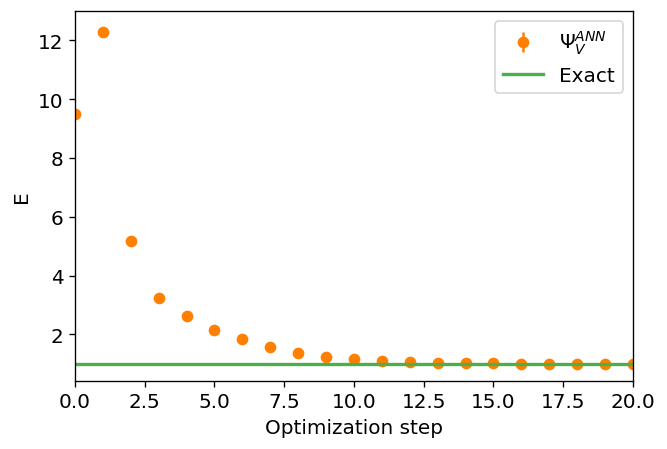

In [11]:
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

step = jnp.asarray(steps_history)
energy = jnp.real(jnp.asarray(energy_history))
error = jnp.real(jnp.asarray(error_history))

p1 = plt.errorbar(step, energy, yerr=error, fmt='o', errorevery=1, markevery = 1, label = r'$\Psi_{V}^{ANN}$', zorder = 0, color = palette(4))
p2 = plt.axhline(y= 0.5 * npart * ndim, linestyle = '-', label = 'Exact', color = palette(2), lw = 2)

#plt.ylim(0.46,1)
plt.xlim(0,20)

plt.xlabel(r'Optimization step')
plt.ylabel('E')
plt.legend([p1, p2], [r'$\Psi_{V}^{ANN}$', r'Exact'], loc = 'upper right')
plt.savefig("ho_energies.pdf",bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


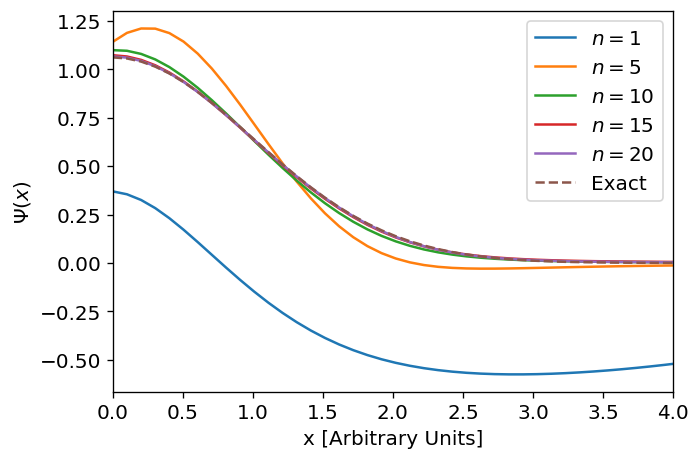

In [12]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# In the one-dimensional case, compare the learned and exact wave functions
x = jnp.linspace(0, 10, 100)

# Define and normalize the exact wave function (e.g., ground state of harmonic oscillator)
psi_exact = jnp.exp(-0.5 * x**2)
psi_exact /= jnp.sqrt(jnp.trapezoid(psi_exact**2, x))

# Evaluate and normalize the ANN wave functions over training checkpoints
psi_ann = []
for params in params_saved:
    psi = jnp.exp(jnp.asarray(wavefunction.vmap_logpsi(params, x)))
    psi /= jnp.sqrt(jnp.trapezoid(psi**2, x))
    psi_ann.append(psi)

# Plotting
figure(figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 12})
palette = plt.get_cmap('Set1')

# Select snapshots to visualize
snapshots = [0, 4, 9, 14, 19]
labels = [r'$n=1$', r'$n=5$', r'$n=10$', r'$n=15$', r'$n=20$']

for idx, label in zip(snapshots, labels):
    plt.plot(x, psi_ann[idx], '-', label=label)

plt.plot(x, psi_exact, '--', label='Exact')

plt.xlabel('x [Arbitrary Units]')
plt.ylabel(r'$\Psi(x)$')
plt.xlim(0, 4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("ho_wavefunction.pdf", bbox_inches='tight')
plt.show()


In [24]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes
sig_i = 1.0         # Gaussian width for sampling the initial configuration
sig = 0.2           # Gaussian width for sampling the Metropolis Move
neq = 10            # Equilibration steps
nav = 10             # Averaging steps
nvoid = 100         # Void steps between energy calculations
nwalk = 400         # Quantum Monte Carlo configurations
ndim = 2            # Spatial dimension
npart = 3           # Number of particles
seed_walk = 19      # Seed to initialize the random-number generator of the Metropolis walk
seed_net = 17       # Seed to initialize the random-number generator of the neural network

key_net = random.PRNGKey(seed_net)
wavefunction = WavefunctionFermion(ndim, npart)
params, nparams = wavefunction.build(key_net)

hamiltonian = Hamiltonian(ndim, npart, wavefunction)
key_walk = random.PRNGKey(seed_walk)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)
optimizer = Optimizer(ndim, npart, nparams, wavefunction)

In [25]:
steps_history = []
energy_history  = []
error_history = []
params_saved = []
for i in range (21):
    key_walk, key_input = jax.random.split(key_walk)
    #value, error, params = step_sgd(i, key_input, params)
    #value, error, params = step_adam(i, key_input, params)
    value, error, params = step_sr(i, key_input, params)
    print("step", i, "energy = ", value, "err=", error )
    steps_history.append(i)
    energy_history.append(value)
    error_history.append(error)
    params_saved.append(params)

step 0 energy =  (23.28944307975279+0.012540737536316321j) err= (0.1805595555632989-0.0003507218932508293j)
step 1 energy =  (13.89796118871445-0.00214865301239443j) err= (0.12194124931843175-0.0006255084693175307j)
step 2 energy =  (10.806728488871464-0.0069043069433858744j) err= (0.08084593458667305+0.00017324734680670582j)
step 3 energy =  (5.952200320719969+0.011713498322485272j) err= (0.0161835951182874+0.0006300007090242101j)
step 4 energy =  (5.575972656387652-0.007852840786292609j) err= (0.006190365029956701+0.0005138961789416299j)
step 5 energy =  (5.369633113154529+0.011755498480892903j) err= (0.0007976810225000967+0.003160914092664965j)
step 6 energy =  (5.242151989281065-0.0057006603127715124j) err= (1.8392698291244078e-06-0.002882817545433062j)
step 7 energy =  (5.168494926432117+0.0005406711139481284j) err= (0.0012698336373620335-0.000399676361751461j)
step 8 energy =  (5.1124284380567895+0.008737769989670784j) err= (1.9281888517422683e-05+0.0014915137570640127j)
step 9 e

In [ ]:
import numpy as np
import math

def ground_state_energy_closed_shell(N, d):
    """
    Ground‐state energy for N spin-polarized fermions filling
    *closed* shells in a d-dimensional harmonic oscillator (m=ω=1).

    Parameters
    ----------
    N : int
        Total number of particles. Must satisfy N = C(nF + d, d) for some integer nF ≥ 0.
    d : int
        Number of spatial dimensions (d ≥ 1).

    Returns
    -------
    E0 : float
        Ground‐state energy E₀ = N * (d*nF/(d+1) + d/2).

    Raises
    ------
    ValueError
        If N does not correspond to a closed shell in dimension d.
    """
    # find the unique nF ≥ 0 such that binomial(nF + d, d) == N
    nF = 0
    while True:
        if math.comb(nF + d, d) == N:
            break
        if math.comb(nF + d, d) > N:
            raise ValueError(f"N={N} is not a closed shell for d={d}")
        nF += 1

    # compute the closed‐shell ground‐state energy
    E0 = N * (d * nF / (d + 1) + d / 2)
    return E0

# Example usage:
E0 = ground_state_energy_closed_shell(npart, ndim)
print('E0=', E0)

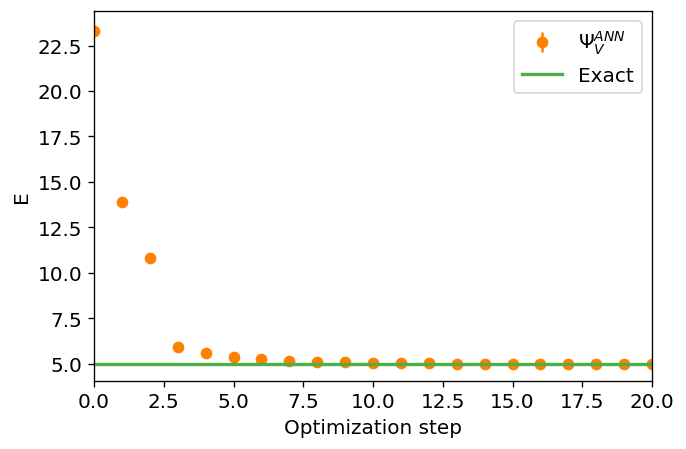

In [26]:
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

E_exact = ground_state_energy_closed_shell(npart, ndim)

step = jnp.asarray(steps_history)
energy = jnp.real(jnp.asarray(energy_history))
error = jnp.real(jnp.asarray(error_history))

p1 = plt.errorbar(step, energy, yerr=error, fmt='o', errorevery=1, markevery = 1, label = r'$\Psi_{V}^{ANN}$', zorder = 0, color = palette(4))
p2 = plt.axhline(y= E_exact, linestyle = '-', label = 'Exact', color = palette(2), lw = 2)

#plt.ylim(0.46,1)
plt.xlim(0,20)

plt.xlabel(r'Optimization step')
plt.ylabel('E')
plt.legend([p1, p2], [r'$\Psi_{V}^{ANN}$', r'Exact'], loc = 'upper right')
plt.savefig("ho_energies.pdf",bbox_inches = 'tight')
plt.show()

E0= 2.0
